In [1]:
import numpy as np
import os
import random
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

import time
from tqdm import tqdm

import pandas as pd

from datetime import datetime

%matplotlib inline
import matplotlib.pylab as plt

import plotly
import plotly.graph_objects as go

In [2]:
df = pd.read_csv("minutes_21.csv")
df["begin"] = pd.to_datetime(df["begin"])
df.head()

,begin,open,close,high,low,value
0,2021-01-04 09:59:00,274.67,274.67,274.67,274.67,33910758.2
1,2021-01-04 10:00:00,274.67,274.00,274.67,273.10,236436377.8
2,2021-01-04 10:01:00,274.00,273.77,274.44,273.72,56647825.9
3,2021-01-04 10:02:00,273.76,273.63,273.84,273.38,55542122.2
4,2021-01-04 10:03:00,273.52,273.71,274.00,273.52,59676343.0


In [21]:
df["rolling"] = df.close.rolling(20).mean()

In [22]:
df.head()

,begin,open,close,high,low,value,rolling
4,2021-01-04 10:03:00,273.52,273.71,274.00,273.52,59676343.0,NaN
5,2021-01-04 10:04:00,273.73,273.85,273.87,273.42,47552546.6,NaN
6,2021-01-04 10:05:00,273.88,273.69,273.97,273.51,40567169.0,NaN
7,2021-01-04 10:06:00,273.70,273.55,273.70,273.30,30101474.4,NaN
8,2021-01-04 10:07:00,273.46,273.45,273.58,273.41,13473180.8,NaN
...,...,...,...,...,...,...,...
210355,2021-12-30 23:45:00,293.48,293.46,293.48,293.31,1073702.1,293.4410
210356,2021-12-30 23:46:00,293.45,293.50,293.50,293.32,3336166.7,293.4355
210357,2021-12-30 23:47:00,293.50,293.33,293.50,293.32,8746644.8,293.4230
210358,2021-12-30 23:48:00,293.35,293.40,293.50,293.20,41674121.8,293.4175


In [23]:
df.dropna(axis=0, inplace=True)

In [24]:
df

,begin,open,close,high,low,value,rolling
23,2021-01-04 10:22:00,273.81,273.90,273.94,273.80,8041935.8,273.7865
24,2021-01-04 10:23:00,273.90,274.44,274.49,273.90,132450225.7,273.8230
25,2021-01-04 10:24:00,274.44,274.19,274.49,274.13,29854031.6,273.8400
26,2021-01-04 10:25:00,274.14,274.23,274.40,274.10,33949266.4,273.8670
27,2021-01-04 10:26:00,274.23,274.25,274.38,274.17,16001039.2,273.9020
...,...,...,...,...,...,...,...
210355,2021-12-30 23:45:00,293.48,293.46,293.48,293.31,1073702.1,293.4410
210356,2021-12-30 23:46:00,293.45,293.50,293.50,293.32,3336166.7,293.4355
210357,2021-12-30 23:47:00,293.50,293.33,293.50,293.32,8746644.8,293.4230
210358,2021-12-30 23:48:00,293.35,293.40,293.50,293.20,41674121.8,293.4175


In [9]:
def data_division(data, period=60, part_len=100):
    """Разбиваем строго внутри дня, по {period} минут, последовательно

    Args:
        data (DataFrame, optional): _description_. Defaults to data.
        period (int, optional): _description_. Defaults to 60.

    Returns:
        DataFrame: _description_
    """

    df_open = data[["begin", "rolling"]]
    df_grouped = df_open.groupby([df_open["begin"].dt.date])
    full_range = []

    for dates in list(df_grouped.groups.keys()):
        df_day = df_grouped.get_group(dates)
        my_list = list(df_day["rolling"])
        composite_list = [
            my_list[x : x + period] for x in range(0, len(my_list), period)
        ]
        # drop last cause not sure if it has full period
        composite_list = composite_list[:-1]
        full_range += composite_list

    new_df = pd.DataFrame(full_range)

    # lets start with small part

    np.random.seed(0)
    new_df = new_df.iloc[list(np.random.choice(range(len(new_df)), part_len))]
    df_norm = TimeSeriesScalerMeanVariance().fit_transform(new_df.values)

    print(new_df.shape)
    print(new_df.head())

    return df_norm

In [10]:
def k_shape_cl(X_train, n_clusters=5):
    sz = X_train.shape[1]

    seed = np.random.seed(0)

    # kShape
    # ks = KShape(n_clusters=n_clusters, verbose=True, random_state=seed)
    sdtw_km = TimeSeriesKMeans(
        n_clusters,
        metric="softdtw",
        metric_params={"gamma": 0.01},
        verbose=True,
        random_state=seed,
    )
    y_pred = sdtw_km.fit_predict(X_train)
    # y_pred = ks.fit_predict(X_train)

    return y_pred, sdtw_km

In [19]:
def cluster_visuliation(model, X_train, y_pred, n_clusters):
    nc = int(n_clusters)
    sz = X_train.shape[1]
    ks = model

    plt.figure(figsize=(12, nc * 4))
    for yi in range(nc):
        plt.subplot(nc, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=0.2)
        plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.title(
            f"Cluster {str(yi + 1)} has {str(X_train[y_pred == yi].shape[0])} timeseries"
        )

    plt.tight_layout()
    plt.show()

In [11]:
def cl_num(X):
    seed = np.random.seed(0)
    distortions = []
    for i in tqdm(range(15, 20)):
        # time.sleep(0.25)
        ks = KShape(n_clusters=i, n_init=5, verbose=False, random_state=seed)
        ks.fit(X)
        distortions.append(ks.inertia_)
    plt.plot(range(15, 20), distortions, marker="o")
    plt.xlabel("Number of clusters")
    plt.ylabel("Distortion Line")
    plt.show()

In [12]:
from tslearn.clustering import silhouette_score


def shape_score(data, labels, metric="dtw"):
    score = silhouette_score(data, labels, metric)
    return score

In [31]:
df_n = data_division(data=df, period=30, part_len=1000)

(1000, 30)
            0         1         2         3         4         5         6   \
2732  310.1070  310.1190  310.1200  310.0985  310.0700  310.0470  310.0185   
2607  301.4615  301.4675  301.4775  301.4885  301.5015  301.5050  301.5100   
1653  292.0535  292.0470  292.0250  292.0145  292.0125  292.0125  292.0170   
3264  311.9725  311.9645  311.9600  311.9560  311.9580  311.9535  311.9515   
4931  324.4925  324.5170  324.5555  324.6025  324.6500  324.6610  324.6715   

            7         8         9   ...        20        21        22  \
2732  310.0000  309.9800  309.9505  ...  309.7685  309.7205  309.6930   
2607  301.5185  301.5265  301.5335  ...  301.5100  301.5130  301.5105   
1653  292.0085  291.9935  291.9790  ...  292.0260  292.0470  292.0800   
3264  311.9495  311.9465  311.9470  ...  311.8835  311.8810  311.8735   
4931  324.6810  324.6950  324.7035  ...  324.6045  324.5775  324.5390   

            23        24        25        26        27        28        29  
2732

In [32]:
y_pred, mod = k_shape_cl(df_n, 10)

4.370 --> 1.837 --> 1.657 --> 1.602 --> 1.581 --> 1.579 --> 1.583 --> 1.579 --> 1.581 --> 1.578 --> 1.576 --> 1.574 --> 1.576 --> 1.576 --> 1.578 --> 1.575 --> 1.576 --> 1.575 --> 1.576 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 1.575 --> 


In [29]:
shape_score(df_n, y_pred)

KeyboardInterrupt: 

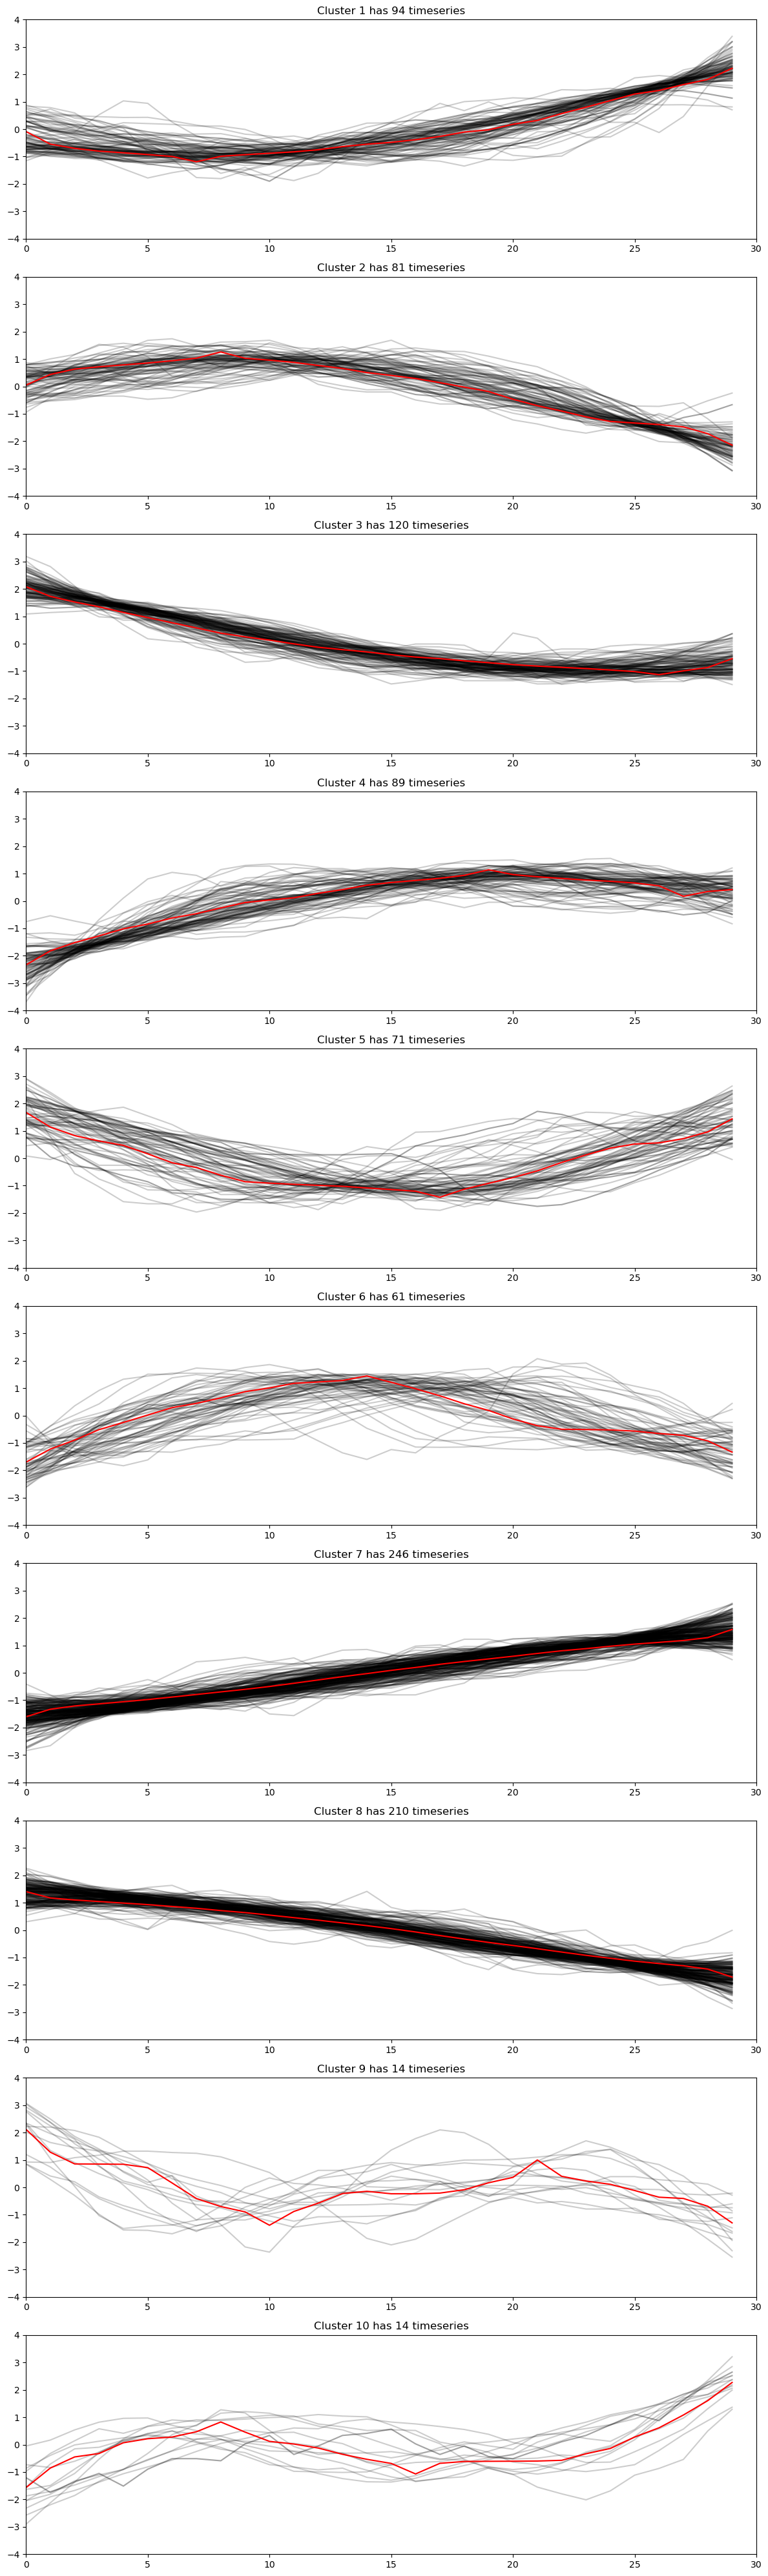

In [33]:
cluster_visuliation(mod, df_n, y_pred, 10)

100%|██████████| 5/5 [15:34<00:00, 186.88s/it]


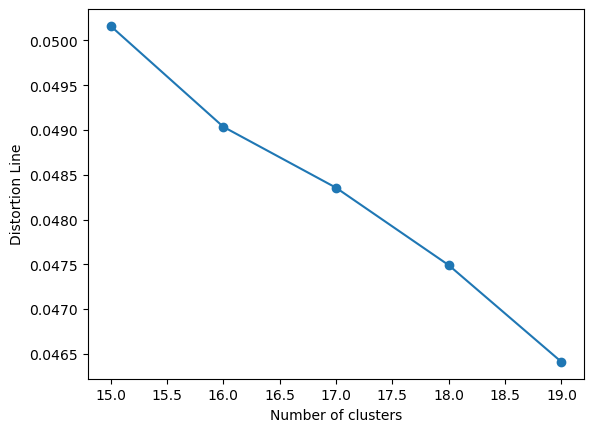

In [45]:
cl_num(df_n)